In [ ]:
from google.colab import files
uploaded = files.upload()

import pandas as pd
df = pd.read_csv('ecommerce_returns_synthetic_data.csv')  # or PATH
print(df.shape)
df.head()


Saving ecommerce_returns_synthetic_data.csv to ecommerce_returns_synthetic_data.csv
(10000, 17)


,Order_ID,Product_ID,User_ID,Order_Date,Return_Date,Product_Category,Product_Price,Order_Quantity,Return_Reason,Return_Status,Days_to_Return,User_Age,User_Gender,User_Location,Payment_Method,Shipping_Method,Discount_Applied
0,ORD00000000,PROD00000000,USER00000000,2023-08-05,2024-08-26,Clothing,411.59,3,Changed mind,Returned,387.0,58,Male,City54,Debit Card,Next-Day,45.27
1,ORD00000001,PROD00000001,USER00000001,2023-10-09,2023-11-09,Books,288.88,3,Wrong item,Returned,31.0,68,Female,City85,Credit Card,Express,47.79
2,ORD00000002,PROD00000002,USER00000002,2023-05-06,NaN,Toys,390.03,5,NaN,Not Returned,NaN,22,Female,City30,Debit Card,Next-Day,26.64
3,ORD00000003,PROD00000003,USER00000003,2024-08-29,NaN,Toys,401.09,3,NaN,Not Returned,NaN,40,Male,City95,PayPal,Next-Day,15.37
4,ORD00000004,PROD00000004,USER00000004,2023-01-16,NaN,Books,110.09,4,NaN,Not Returned,NaN,34,Female,City80,Gift Card,Standard,16.37


In [ ]:
df.info()
df.isnull().sum().sort_values(ascending=False).head(10)
df['Return_Status'].value_counts(normalize=True).rename('share')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Order_ID          10000 non-null  object 
 1   Product_ID        10000 non-null  object 
 2   User_ID           10000 non-null  object 
 3   Order_Date        10000 non-null  object 
 4   Return_Date       5052 non-null   object 
 5   Product_Category  10000 non-null  object 
 6   Product_Price     10000 non-null  float64
 7   Order_Quantity    10000 non-null  int64  
 8   Return_Reason     5052 non-null   object 
 9   Return_Status     10000 non-null  object 
 10  Days_to_Return    5052 non-null   float64
 11  User_Age          10000 non-null  int64  
 12  User_Gender       10000 non-null  object 
 13  User_Location     10000 non-null  object 
 14  Payment_Method    10000 non-null  object 
 15  Shipping_Method   10000 non-null  object 
 16  Discount_Applied  10000 non-null  float64

,share
Return_Status,
Returned,0.5052
Not Returned,0.4948


In [ ]:
df.columns = df.columns.str.strip()

df['return_flag'] = (df['Return_Status'].str.strip().eq('Returned')).astype(int)

df['Order_Date'] = pd.to_datetime(df['Order_Date'])
df['order_year']  = df['Order_Date'].dt.year
df['order_month'] = df['Order_Date'].dt.month
df['order_dow']   = df['Order_Date'].dt.dayofweek
df['User_Age'] = df['User_Age'].clip(lower=13, upper=100)
df['Product_Price'] = df['Product_Price'].clip(lower=0)


df = df.drop_duplicates()
df.shape


(10000, 21)

Overall return rate: 50.52%


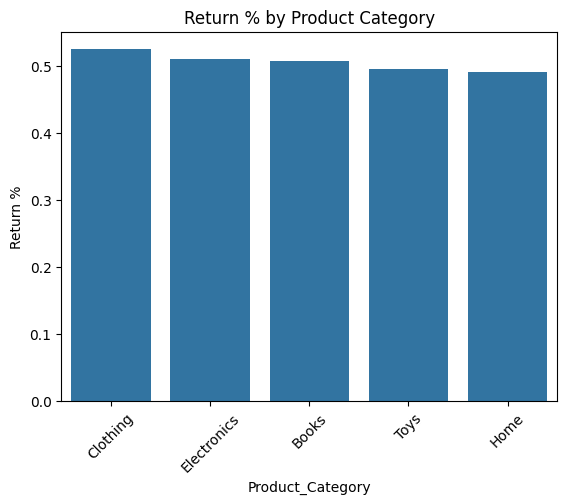

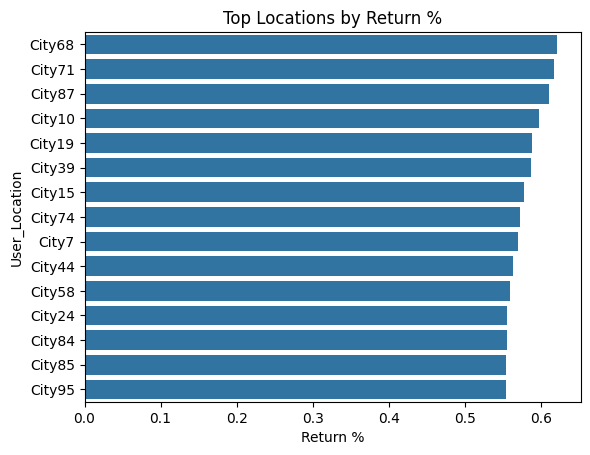

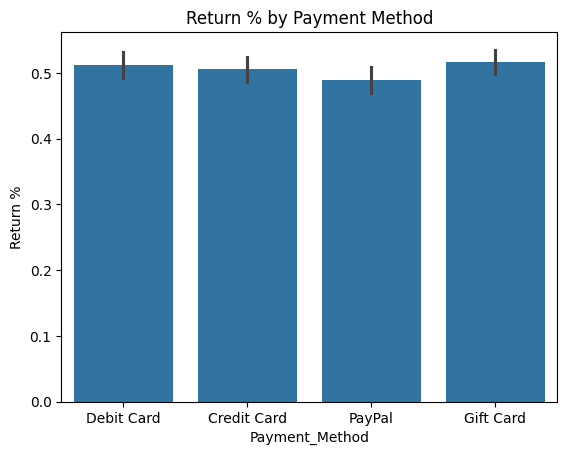

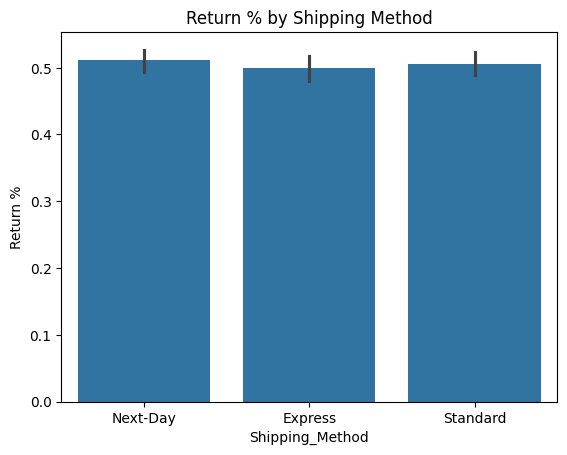

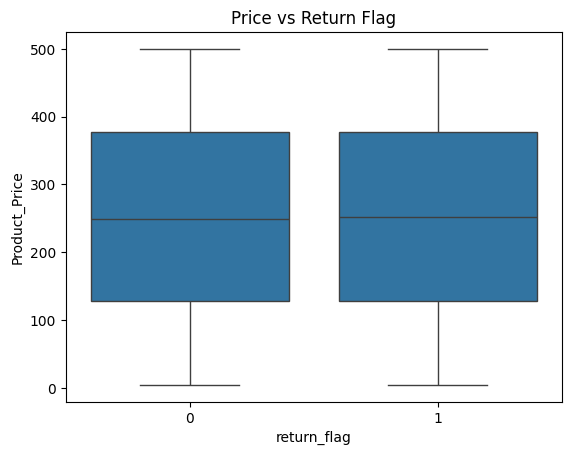

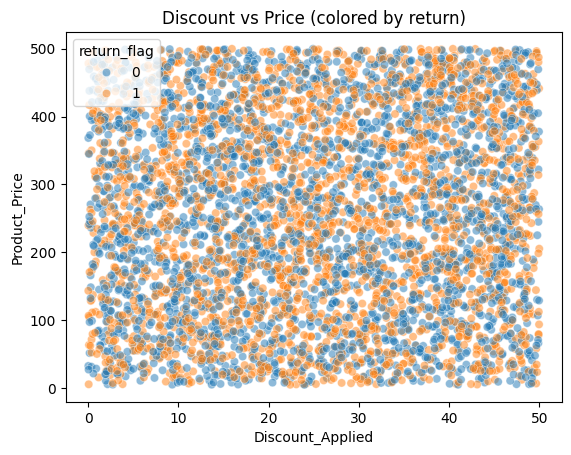

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


overall = df['return_flag'].mean() * 100
print(f"Overall return rate: {overall:.2f}%")

# Return % by category
cat_rate = df.groupby('Product_Category')['return_flag'].mean().sort_values(ascending=False)
sns.barplot(x=cat_rate.index, y=cat_rate.values)
plt.title('Return % by Product Category'); plt.xticks(rotation=45); plt.ylabel('Return %'); plt.show()

# Top regions by return %
reg_rate = df.groupby('User_Location')['return_flag'].mean().sort_values(ascending=False).head(15)
sns.barplot(y=reg_rate.index, x=reg_rate.values)
plt.title('Top Locations by Return %'); plt.xlabel('Return %'); plt.show()

# Channel & shipping impact
sns.barplot(data=df, x='Payment_Method', y='return_flag')
plt.title('Return % by Payment Method'); plt.ylabel('Return %'); plt.show()

sns.barplot(data=df, x='Shipping_Method', y='return_flag')
plt.title('Return % by Shipping Method'); plt.ylabel('Return %'); plt.show()

# Price/Discount relationship
sns.boxplot(data=df, x='return_flag', y='Product_Price')
plt.title('Price vs Return Flag'); plt.show()

sns.scatterplot(data=df.sample(min(5000, len(df)), random_state=42),
                x='Discount_Applied', y='Product_Price', hue='return_flag', alpha=0.5)
plt.title('Discount vs Price (colored by return)'); plt.show()


In [ ]:
features = [
    'Product_Category','Product_Price','Order_Quantity','User_Age','User_Gender',
    'User_Location','Payment_Method','Shipping_Method','Discount_Applied',
    'order_year','order_month','order_dow'
]
target = 'return_flag'

X = df[features].copy()
y = df[target].copy()

cat_cols = X.select_dtypes(include=['object']).columns.tolist()
num_cols = [c for c in X.columns if c not in cat_cols]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
    ]
)

log_reg = LogisticRegression(max_iter=1000, n_jobs=-1)

pipe = Pipeline(steps=[
    ('preprocess', preprocess),
    ('model', log_reg)
])

pipe.fit(X_train, y_train)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Product_Price',
                                                   'Order_Quantity', 'User_Age',
                                                   'Discount_Applied',
                                                   'order_year', 'order_month',
                                                   'order_dow']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Product_Category',
                                                   'User_Gender',
                                                   'User_Location',
                                                   'Payment_Method',
                                                   'Shipping_Method'])])),
                ('model', LogisticRegression(max_iter=1000, n_jobs=-1))])

              precision    recall  f1-score   support

           0       0.49      0.45      0.47       990
           1       0.50      0.55      0.53      1010

    accuracy                           0.50      2000
   macro avg       0.50      0.50      0.50      2000
weighted avg       0.50      0.50      0.50      2000

ROC AUC: 0.488019801980198


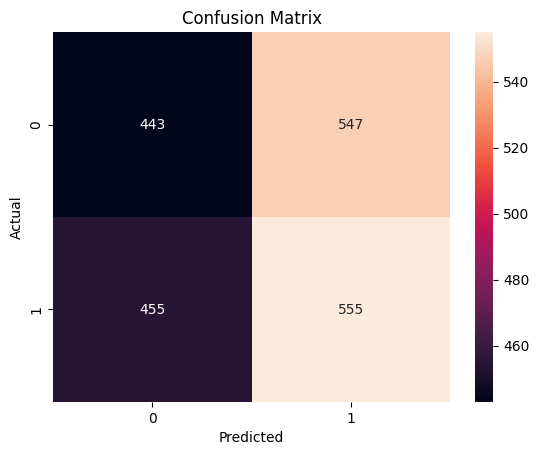

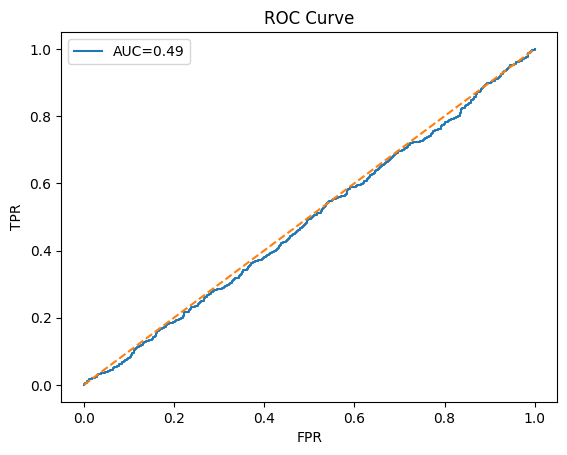

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import numpy as np

y_prob = pipe.predict_proba(X_test)[:,1]
y_pred = (y_prob >= 0.5).astype(int)

print(classification_report(y_test, y_pred))
print('ROC AUC:', roc_auc_score(y_test, y_prob))


cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix'); plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.show()


fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label=f'AUC={roc_auc_score(y_test, y_prob):.2f}')
plt.plot([0,1],[0,1],'--')
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC Curve'); plt.legend(); plt.show()


In [ ]:
ohe = pipe.named_steps['preprocess'].named_transformers_['cat']
ohe_features = ohe.get_feature_names_out(cat_cols)
final_feature_names = np.r_[num_cols, ohe_features]

coefs = pipe.named_steps['model'].coef_.ravel()
feat_importance = pd.Series(coefs, index=final_feature_names).sort_values(key=abs, ascending=False)
feat_importance.head(25)


,0
User_Location_City25,-0.543541
User_Location_City68,0.509939
User_Location_City32,-0.477862
User_Location_City45,-0.458627
User_Location_City38,0.456927
User_Location_City1,-0.426624
User_Location_City91,-0.426192
User_Location_City44,0.410516
User_Location_City41,-0.394803
User_Location_City74,0.385501


In [ ]:
df_scores = df[['Order_ID','Product_ID','User_ID'] + features].copy()
df_scores['return_probability'] = pipe.predict_proba(df_scores[features])[:,1]
threshold = 0.60
df_scores['high_risk_flag'] = (df_scores['return_probability'] >= threshold).astype(int)

df_scores.to_csv('orders_with_return_probabilities.csv', index=False)
df_scores[df_scores['high_risk_flag']==1].to_csv('high_risk_products.csv', index=False)

print(df_scores['high_risk_flag'].mean(), 'share flagged as high risk')
df_scores.head()


0.0638 share flagged as high risk


,Order_ID,Product_ID,User_ID,Product_Category,Product_Price,Order_Quantity,User_Age,User_Gender,User_Location,Payment_Method,Shipping_Method,Discount_Applied,order_year,order_month,order_dow,return_probability,high_risk_flag
0,ORD00000000,PROD00000000,USER00000000,Clothing,411.59,3,58,Male,City54,Debit Card,Next-Day,45.27,2023,8,5,0.548703,0
1,ORD00000001,PROD00000001,USER00000001,Books,288.88,3,68,Female,City85,Credit Card,Express,47.79,2023,10,0,0.525997,0
2,ORD00000002,PROD00000002,USER00000002,Toys,390.03,5,22,Female,City30,Debit Card,Next-Day,26.64,2023,5,5,0.504270,0
3,ORD00000003,PROD00000003,USER00000003,Toys,401.09,3,40,Male,City95,PayPal,Next-Day,15.37,2024,8,3,0.490032,0
4,ORD00000004,PROD00000004,USER00000004,Books,110.09,4,34,Female,City80,Gift Card,Standard,16.37,2023,1,0,0.484673,0


In [ ]:

df_scores = df.copy()
df_scores['return_probability'] = pipe.predict_proba(df[features])[:, 1]


threshold = 0.6
df_scores['high_risk_flag'] = (df_scores['return_probability'] >= threshold).astype(int)


df_scores.to_csv("ecommerce_cleaned.csv", index=False)

print("File exported: ecommerce_cleaned.csv")
df_scores.head()


File exported: ecommerce_cleaned.csv


,Order_ID,Product_ID,User_ID,Order_Date,Return_Date,Product_Category,Product_Price,Order_Quantity,Return_Reason,Return_Status,...,User_Location,Payment_Method,Shipping_Method,Discount_Applied,return_flag,order_year,order_month,order_dow,return_probability,high_risk_flag
0,ORD00000000,PROD00000000,USER00000000,2023-08-05,2024-08-26,Clothing,411.59,3,Changed mind,Returned,...,City54,Debit Card,Next-Day,45.27,1,2023,8,5,0.548703,0
1,ORD00000001,PROD00000001,USER00000001,2023-10-09,2023-11-09,Books,288.88,3,Wrong item,Returned,...,City85,Credit Card,Express,47.79,1,2023,10,0,0.525997,0
2,ORD00000002,PROD00000002,USER00000002,2023-05-06,NaN,Toys,390.03,5,NaN,Not Returned,...,City30,Debit Card,Next-Day,26.64,0,2023,5,5,0.504270,0
3,ORD00000003,PROD00000003,USER00000003,2024-08-29,NaN,Toys,401.09,3,NaN,Not Returned,...,City95,PayPal,Next-Day,15.37,0,2024,8,3,0.490032,0
4,ORD00000004,PROD00000004,USER00000004,2023-01-16,NaN,Books,110.09,4,NaN,Not Returned,...,City80,Gift Card,Standard,16.37,0,2023,1,0,0.484673,0


In [ ]:
from google.colab import files
files.download("ecommerce_cleaned.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>